In [1]:
#!python3

# imports
import sys
import numpy as np
from lmfit import minimize, Parameters, report_fit
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
# Functions to define fit
def logit_growth(K, R0, r, t):
    return((K*R0*np.exp(r*t)) / (K + R0*(np.exp(r*t) - 1)))

# Vectorised for plotting
vec_growth = np.vectorize(logit_growth)

def residual(params, t, data):
    K = params['K']
    R0 = params['R0']
    r = params['r']

    model = logit_growth(K, R0, r, t)

    return (data - model)

In [3]:
# Read in data
with open("../cfu_time.tsv", 'r') as observations:
    header = observations.readline()
    data = []
    for line in observations:
        time, cfu = line.rstrip().split("\t")
        data.append((float(time), float(cfu)))
    data = np.asarray(data)

In [4]:
# Start values

# with intercept
# reg_x = np.hstack((np.ones(data.shape[0]).reshape(-1, 1),
#                         data[:, 0].reshape(-1, 1))

reg_x = data[:, 0]
regression = smf.OLS(np.log(data[:, 1]), reg_x).fit()
r_start = regression.params[0]

K_start = np.amax(data[:,1])

In [5]:
# Perform fit
params = Parameters()
params.add('K', value=K_start, min = 1, max=10**5)
params.add('R0', value=1, vary=False)
params.add('r', value=r_start, min = 0, max = 5)

out = minimize(residual, params, args=(data[:, 0], data[:, 1]))

report_fit(out)

[[Fit Statistics]]
    # function evals   = 48
    # data points      = 46
    # variables        = 2
    chi-square         = 3692169300.147
    reduced chi-square = 83912938.640
    Akaike info crit   = 841.239
    Bayesian info crit = 844.896
[[Variables]]
    K:    43614.9711 +/- 3.54e+03 (8.11%) (init= 62000)
    R0:   1 (fixed)
    r:    1.03239798 +/- 0.034540 (3.35%) (init= 0.6901732)
[[Correlations]] (unreported correlations are <  0.100)
    C(K, r)                      = -0.482 


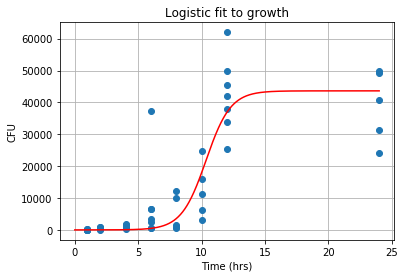

In [16]:
# Plot results
t = np.linspace(0, 24, 1000)
N = vec_growth(out.params['K'].value, 1, out.params['r'].value, t)

f1 = plt.figure()

plt.plot(data[:, 0], data[:, 1], 'o')
plt.plot(t, N, 'r-')

plt.grid()
plt.legend(loc='best')
plt.xlabel('Time (hrs)')
plt.ylabel('CFU')
plt.title("Logistic fit to growth")

f1.savefig("lmfit_growth.pdf")
plt.show()

In [ ]:
sys.exit(0)